In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from itertools import product


Загрузим датасеты

In [126]:
df_iris = pd.read_csv('iris.csv')
df_adm = pd.read_csv('admission.csv')

Теперь давайте сделаем оверсемплинг всех классов в датасете с ирисами. Я сделаю это не из-за дисбаланса классов, а для увеличения размера выборки. Так будет сложнее получить большие метрики, чем на исходном маленьком датасете.

In [127]:
X = df_iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df_iris['species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

sampling_strategy_dict = {0: 200, 1: 200, 2: 200}

smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42, k_neighbors=10)
X_resampled, y_resampled_encoded = smote.fit_resample(X, y_encoded)

y_resampled = le.inverse_transform(y_resampled_encoded)

df_iris_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_iris_resampled['species'] = y_resampled

print("\nРаспределение классов после оверсэмплинга:\n", df_iris_resampled['species'].value_counts())
print("\nНовый размер датасета:", df_iris_resampled.shape)


Распределение классов после оверсэмплинга:
 species
Iris-setosa        200
Iris-versicolor    200
Iris-virginica     200
Name: count, dtype: int64

Новый размер датасета: (600, 5)


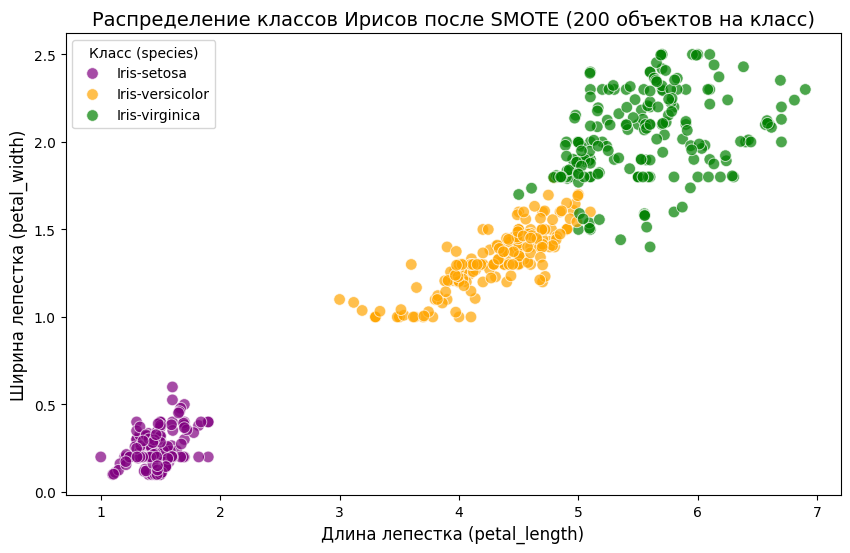

In [42]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_iris_resampled,
    x='petal_length',
    y='petal_width',
    hue='species', 
    palette=['purple', 'orange', 'green'],
    s=70,
    alpha=0.7
)

plt.title('Распределение классов Ирисов после SMOTE (200 объектов на класс)', fontsize=14)
plt.xlabel('Длина лепестка (petal_length)', fontsize=12)
plt.ylabel('Ширина лепестка (petal_width)', fontsize=12)
plt.legend(title='Класс (species)')
plt.show()

**КЛАССИФИКАЦИЯ**

**Бейзлайн**

In [207]:
X = df_iris_resampled.drop('species', axis=1)
y = df_iris_resampled['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Classification Baseline")
print(f"Accuracy: {acc:.4f}")

Classification Baseline
Accuracy: 0.9667


Хороший результат, попробуем запустить тот же самоый алгоритм, но с поиском оптимальных гиперпараметров на сетке.

**Улучшения**

In [90]:
param_grid_cls = {
    'max_depth': [2, 3, 4, 5, 6, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

Выполним поиск гиперпараметров на сетке с кросс-валидацией

In [91]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.3, random_state=42)

grid_cls = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_cls, cv=5, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_c, y_train_c)

best_cls_model = grid_cls.best_estimator_
y_pred_new_c = best_cls_model.predict(X_test_c)
acc_new = accuracy_score(y_test_c, y_pred_new_c)

print(f"Improved Accuracy: {acc_new:.4f}")
print(f"Лучшие параметры: {grid_cls.best_params_}")

Improved Accuracy: 0.9667
Лучшие параметры: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Результат:** мы получили хорошие значения метрики и на базовом и на улучшенном решении. Более того, метрики получились одинаковые, потому что оптимальными гиперпараметрами оказались дефолнтные. В целом дерево решений хорошо справилось с этой задачей и точно не переобучилось - глубина всего лишь 4 слоя.

**РЕГРЕССИЯ**

**Бейзлайн**

In [101]:
X_adm = df_adm.drop(['Chance of Admit ', 'Serial No.'], axis=1)
y_adm = df_adm['Chance of Admit ']
    
X_train_adm, X_test_adm, y_train_adm, y_test_adm = train_test_split(X_adm, y_adm, test_size=0.3, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_adm, y_train_adm)

y_pred_adm = model.predict(X_test_adm)
r2_adm = r2_score(y_test_adm, y_pred_adm)
mae_adm = mean_absolute_error(y_test_adm, y_pred_adm)

print(f"\nRegression Baseline")
print(f"R2: {r2_adm:.4f}")
print(f"MAE: {mae_adm:.4f}")


Regression Baseline
R2: 0.5091
MAE: 0.0755


Для регрессии мы получили посредственные значения метрик. Коэффициент детерминации равен 0.5, а это значит, что лишь 50 процентов от корреляции данных обьясняется моделью. Это достаточно маленькая метрика.

Посмотрим, какие параметры задаются в регрессоре по умолчанию, чтобы потом сравнить с теми, которые мы получим на кросс-валидации

In [98]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

**Улучшения**

Выполниим подбор гиперпараметров по сетке с кросс-валидацией. Для деревянных алгоритмов гиперпараметры уже другие.

**max_depth** - Максимальная глубина дерева;  
**min_samples_split** - мин. кол-во объектов для разделения, сколько минимум примеров должно быть в узле, чтобы дерево попыталось разделить его на две ветки;  
**min_samples_leaf** - мин. кол-во объектов в листе, сколько примеров обязано остаться в конечном узле;  
**max_features** - макс. кол-во признаков, сколько колонок алгоритм просматривает, когда ищет лучшее разделение в конкретном узле.  
Если использовать не все признаки сразу, а случайную часть (sqrt или log2), деревья получаются более разнообразными и менее склонными зацикливаться на одном доминирующем признаке.  
**criterion** - критерий, метрика, по которой оценивается разделение.

In [100]:
param_grid_reg = {
    'max_depth': [3, 4, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 30], 
    'max_features': [None, 'sqrt'] 
}

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_adm, y_adm, test_size=0.3, random_state=42)

grid_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_reg, cv=5, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_r, y_train_r)

best_reg_model = grid_reg.best_estimator_
y_pred_new_r = best_reg_model.predict(X_test_r)

r2_new = r2_score(y_test_r, y_pred_new_r)
mae_new = mean_absolute_error(y_test_r, y_pred_new_r)

print(f"Improved R2:  {r2_new:.4f}")
print(f"Improved MAE: {mae_new:.4f}")
print(f"Лучшие параметры: {grid_reg.best_params_}")

Improved R2:  0.7668
Improved MAE: 0.0524
Лучшие параметры: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


Видим очень значительную прибавку по метрикам.  
Подбор гиперпараметров для деревянных алгоритмов очень важен. Например параметр **min_samples_leaf** работает своего рода регуляризатором, потому что не дает создать дереву еще один лист для отдельного единичного выброса, а **max_depth** нужно ограничивать, чтобы дерево не было бесконечно глубоким и не запомнила всю выборку, выделя по листу на каждый элемент обучающей выборки.

Взглянем на feachure importance


Важность признаков
CGPA                 0.945186
GRE Score            0.030030
University Rating    0.012281
TOEFL Score          0.006394
Research             0.006109
SOP                  0.000000
LOR                  0.000000
dtype: float64


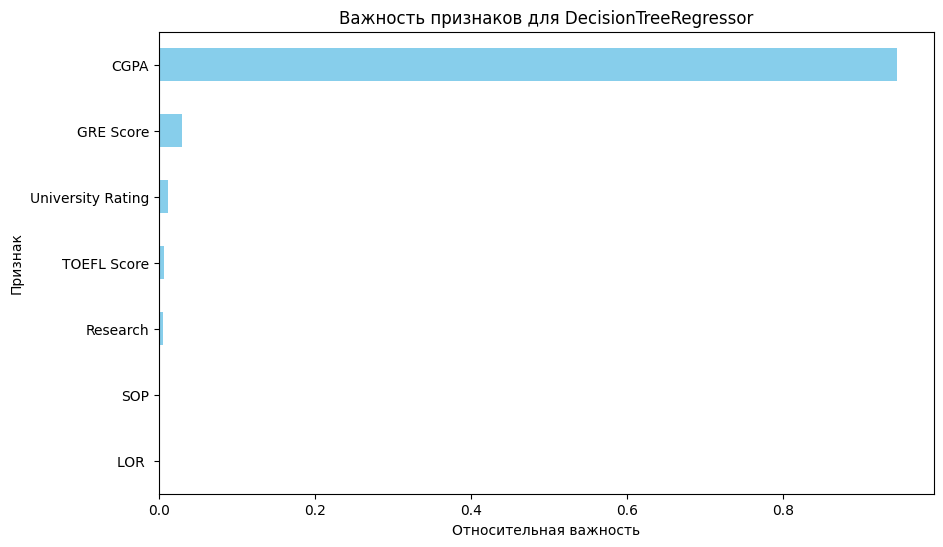

In [105]:
feature_names = X_train_r.columns
importances = best_reg_model.feature_importances_

feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nВажность признаков")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
feature_importance_df.plot(kind='barh', color='skyblue')
plt.title('Важность признаков для DecisionTreeRegressor')
plt.xlabel('Относительная важность')
plt.ylabel('Признак')
plt.gca().invert_yaxis() # Сортируем самый важный сверху
plt.show()

**ИМПЛЕМЕНТАЦИЯ**

Переиспользуем некоторые функции из прошлых ЛР

In [183]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_mean)**2)
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)

def train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

In [184]:
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1.0 
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler не обучен. Вызовите 'fit' перед 'transform'.")
        return (X - self.mean_) / self.scale_

In [216]:
def custom_k_fold_split(X, y, n_splits=5, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield (train_indices, test_indices)
        current = stop

def custom_grid_search(X_train, y_train, model_class, param_grid,
                       n_splits=5, scoring='r2'):
    
    maximize_metrics = {'accuracy', 'r2', 'f1'}
    minimize_metrics = {'mae', 'mse'}
    
    if scoring in maximize_metrics:
        compare = lambda new, best: new > best
        best_score = -np.inf
    elif scoring in minimize_metrics:
        compare = lambda new, best: new < best
        best_score = np.inf
    else:
        raise ValueError(f"Метрика '{scoring}' не поддерживается")

    best_params = None

    keys, values = zip(*param_grid.items())
    
    for params in product(*values):
        param_dict = dict(zip(keys, params))
        fold_scores = []

        for tr_idx, val_idx in custom_k_fold_split(X_train, y_train, n_splits=n_splits):
            X_tr = X_train.iloc[tr_idx]
            X_val = X_train.iloc[val_idx]
            
            y_tr = y_train.iloc[tr_idx]
            y_val = y_train.iloc[val_idx]

            model = model_class(**param_dict)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)

            if scoring == 'r2':
                score = calculate_r2(y_val, pred)
            elif scoring == 'mae':
                score = calculate_mae(y_val, pred)
            elif scoring == 'accuracy':
                score = np.mean(y_val == pred)
            else:
                raise ValueError(f"Метрика '{scoring}' не поддерживается")

            fold_scores.append(score)

        mean_score = np.mean(fold_scores)

        print(f"{param_dict} -> {scoring}={mean_score:.4f}")

        if compare(mean_score, best_score):
            best_score = mean_score
            best_params = param_dict

    return best_params, best_score


**Классификация**

In [193]:
class DecisionTreeClassifierСustom:
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        criterion="gini"
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features 
        self.criterion = criterion
        self.tree_ = None

    class Node:
        def __init__(self, feature_index=None, threshold=None,
                     left=None, right=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        p = counts / m
        return 1 - np.sum(p*p)

    def _entropy(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        p = counts / m
        p = p[p > 0]
        return -np.sum(p * np.log2(p))

    def _criterion_func(self, y):
        if self.criterion == "gini":
            return self._gini(y)
        elif self.criterion == "entropy":
            return self._entropy(y)
        else:
            raise ValueError("Unknown criterion")

    def _best_split(self, X, y):
        m, n_features = X.shape

        if self.max_features is None:
            features = range(n_features)
        else:
            k = min(self.max_features, n_features)
            features = np.random.choice(n_features, k, replace=False)

        best_score = float("inf")
        best_idx, best_thr = None, None

        for feature_idx in features:
            thresholds = np.unique(X[:, feature_idx])

            for thr in thresholds:
                mask_left = X[:, feature_idx] <= thr
                mask_right = ~mask_left
                y_left, y_right = y[mask_left], y[mask_right]

                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                score_left = self._criterion_func(y_left)
                score_right = self._criterion_func(y_right)

                weighted = (len(y_left) * score_left + len(y_right) * score_right) / m

                if weighted < best_score:
                    best_score = weighted
                    best_idx = feature_idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        classes, counts = np.unique(y, return_counts=True)
        prediction = classes[np.argmax(counts)]
        node = self.Node(value=prediction)

        if depth < (self.max_depth if self.max_depth is not None else np.inf) \
            and len(y) >= self.min_samples_split:

            idx, thr = self._best_split(X, y)

            if idx is not None:
                mask_left = X[:, idx] <= thr
                X_left, y_left = X[mask_left], y[mask_left]
                X_right, y_right = X[~mask_left], y[~mask_left]

                node.feature_index = idx
                node.threshold = thr
                node.left = self._build_tree(X_left, y_left, depth + 1)
                node.right = self._build_tree(X_right, y_right, depth + 1)
                node.value = None

        return node

    def fit(self, X, y):
        self.tree_ = self._build_tree(np.array(X), np.array(y))

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_one(x, self.tree_) for x in X])

**Бейзлайн**

In [205]:
X = df_iris_resampled.drop('species', axis=1)
y = df_iris_resampled['species']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [206]:
clf = DecisionTreeClassifierСustom()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", calculate_accuracy(y_test, y_pred))

Accuracy: 0.9666666666666667


**Результаты и сравнение:** Получили неплохой результат для бейзлайна. Но это значения, получшенные на дефолтных значениях гиперпараметров. Скорее всего метрику можно улучшить, например, ограничив глубину дерева, тем самым не допустив переобучения. В любом случае попробуем подобрать гиперпараметры на сетке.
Ну и в сравнении с библиотечным решением мы получили точно такие же резульаты.

**Улучшения**

In [202]:
param_grid_cls = {
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 3],
    "criterion": ["gini", "entropy"],
}

best_params_cls, best_score_cls = custom_grid_search(
    X_train,
    y_train,
    DecisionTreeClassifierСustom,
    param_grid_cls,
    n_splits=5,
    scoring="accuracy"
)

print("\nЛучшие параметры (классификация):", best_params_cls)
print("Лучший k-fold accuracy:", best_score_cls)

best_model_cls = DecisionTreeClassifierСustom(**best_params_cls)
best_model_cls.fit(X_train, y_train)

y_pred = best_model_cls.predict(X_test)

print("Final Test Accuracy:", calculate_accuracy(y_test, y_pred))

{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'} -> accuracy=0.9694
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'} -> accuracy=0.9722
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'} -> accuracy=0.9722
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'} -> accuracy=0.9750
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini'} -> accuracy=0.9722
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'entropy'} -> accuracy=0.9750
{'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'} -> accuracy=0.9694
{'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy'} -> accuracy=0.9722
{'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini'} -> accuracy=0.9722
{'max_depth': 3, 'min_samples_split': 4, 'min_sample

Видим улучшения, которые получились после подбора гиперпараметров на сетке. Так же можно наблюдать, что тестовые значения получаются всегда меньше, чем тренировочные на самом лучшем фолде. Это показывает, что наш алгоритм не переобучился, а генерализовал данные из обучающей выборки.

In [215]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
108,6.700000,2.500000,5.800000,1.800000
272,5.529814,4.140371,1.444721,0.214907
599,6.251326,2.748674,4.851326,1.800000
479,6.700000,3.300000,5.700000,2.418776
436,6.092770,2.898192,4.696385,1.398192
...,...,...,...,...
71,6.100000,2.800000,4.000000,1.300000
106,4.900000,2.500000,4.500000,1.700000
270,5.140451,3.619098,1.500000,0.319098
435,5.682407,2.782407,4.117593,1.300000


**РЕГРЕССИЯ**

**Безйлайн**

In [220]:
class DecisionTreeRegressorCustom:
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        criterion="mse"
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.criterion = criterion
        self.tree_ = None

    class Node:
        def __init__(self, feature_index=None, threshold=None,
                     left=None, right=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _mse(self, y):
        mean = np.mean(y)
        return np.mean((y - mean)**2)

    def _mae(self, y):
        median = np.median(y)
        return np.mean(np.abs(y - median))

    def _criterion_func(self, y):
        if self.criterion == "mse":
            return self._mse(y)
        elif self.criterion == "mae":
            return self._mae(y)
        else:
            raise ValueError("Unknown criterion")

    def _best_split(self, X, y):
        m, n_features = X.shape

        if self.max_features is None:
            features = range(n_features)
        else:
            k = min(self.max_features, n_features)
            features = np.random.choice(n_features, k, replace=False)

        best_score = float("inf")
        best_idx, best_thr = None, None

        for feature_idx in features:
            thresholds = np.unique(X[:, feature_idx])

            for thr in thresholds:
                mask_left = X[:, feature_idx] <= thr
                mask_right = ~mask_left
                y_left, y_right = y[mask_left], y[mask_right]

                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                score_left = self._criterion_func(y_left)
                score_right = self._criterion_func(y_right)
                weighted = (len(y_left) * score_left + len(y_right) * score_right) / m

                if weighted < best_score:
                    best_score = weighted
                    best_idx = feature_idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        value = np.mean(y)
        node = self.Node(value=value)

        if depth < (self.max_depth if self.max_depth is not None else np.inf) \
            and len(y) >= self.min_samples_split:

            idx, thr = self._best_split(X, y)
            if idx is not None:
                mask_left = X[:, idx] <= thr
                X_left, y_left = X[mask_left], y[mask_left]
                X_right, y_right = X[~mask_left], y[~mask_left]

                node.feature_index = idx
                node.threshold = thr
                node.left = self._build_tree(X_left, y_left, depth + 1)
                node.right = self._build_tree(X_right, y_right, depth + 1)
                node.value = None

        return node

    def fit(self, X, y):
        self.tree_ = self._build_tree(np.array(X, float), np.array(y, float))

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        X = np.array(X, float)
        return np.array([self._predict_one(x, self.tree_) for x in X], float)

**Бейзлайн**

In [159]:
X_adm = df_adm.drop(['Chance of Admit ', 'Serial No.'], axis=1)
y_adm = df_adm['Chance of Admit ']
    
X_train_adm, X_test_adm, y_train_adm, y_test_adm = train_test_split(X_adm, y_adm, test_size=0.3, random_state=42)


reg = DecisionTreeRegressorCustom()
reg.fit(X_train_adm, y_train_adm)
y_pred_adm = reg.predict(X_test_adm)

print("MAE:", calculate_mae(y_test_adm, y_pred_adm))
print("R2:", calculate_r2(y_test_adm, y_pred_adm))

MAE: 0.07133333333333333
R2: 0.5849298820221702


Для регрессии мы получили посредственные значения метрик. Коэффициент детерминации равен 0.6, а это значит, что лишь 60 процентов от корреляции данных обьясняется моделью. Это достаточно маленькая метрика.

**Улучшения**

In [223]:
param_grid_reg = {
    'max_depth': [3, 4, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 30], 
}

best_params_reg, best_score_reg = custom_grid_search(
    X_train_adm,
    y_train_adm,
    DecisionTreeRegressorCustom,
    param_grid_reg,
    n_splits=5,
    scoring="r2"
)

print("\nЛучшие параметры (регрессия):", best_params_reg)
print("Лучший k-fold accuracy:", best_score_reg)

best_model_reg = DecisionTreeRegressorCustom(**best_params_reg)
best_model_reg.fit(X_train_adm, y_train_adm)

y_pred_adm = best_model_reg.predict(X_test_adm)

r2_adm = r2_score(y_test_adm, y_pred_adm)
mae_adm = mean_absolute_error(y_test_adm, y_pred_adm)

print(f"Improved R2:  {r2_adm:.4f}")
print(f"Improved MAE: {mae_adm:.4f}")

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 20} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 30} -> r2=0.6936
{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 20} -> r2=0.6946
{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 30} -> r2=0.6936
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2} -> r2=0.6951
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10} -> r2=0.6951
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 20} -> r2=0.6951
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 30} -> r2=0.6941
{'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 2

В результате мы получили значительный прирост в метриках благодаря использованию оптимальных гиперпараметров. Прирост в R2 с 0.6 до 0.8 - это очень хороший результат.   
В библиотечной версии с подброром гиперпараметров вышли метрики R2 и MAE 0.7668 и 0.524 соответственно. Это лишь на тысячные доли лучше, чем полученные в ручной имлпементации, что я бы счел очень хорошим результатом. 